In [1]:
# Block 1
import os
import sys
file_path = os.path.abspath('./utils')
print(file_path)
sys.path.append(file_path)

import CommonUtil as cu

os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

import glob # List 불러오는 라이브러리
import numpy as np # 배열처리하는 라이브러리
import sys
import cv2
from sklearn.utils import shuffle

import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import matplotlib.pyplot as plt# 이미지, 그래프 보는 라이브러리

from tqdm import tqdm, tqdm_notebook
import pandas as pd
import SimpleITK as sitk

from absl import logging
logging._warn_preinit_stderr = 0
logging.warning('Worrying Stuff')


/home/gil/gcubme_ai2/Workspace/SB_MUN/19_liver/4_참고자료/1_source/utils


2024-05-21 16:52:45.263714: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 16:52:45.927129: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gil/anaconda3/envs/msb_2.11.0/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/cuda-11.3/lib64:
2024-05-21 16:52:45.927545: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gil/anaconda3/e

In [2]:
# Block 2
base_dir = os.path.abspath(f'../0_data/data_preprocessing')
saveDir= os.path.abspath(f'../2_result')

print(base_dir)
print(saveDir)

image_list = sorted(glob.glob(f'{base_dir}/image/*.png'))
label_list = [path.replace('/image/', '/label/liver/') for path in image_list]

print(len(image_list), image_list[0])
print(len(label_list), label_list[0])


/home/gil/gcubme_ai2/Workspace/SB_MUN/19_liver/4_참고자료/0_data/data_preprocessing
/home/gil/gcubme_ai2/Workspace/SB_MUN/19_liver/4_참고자료/2_result
131 /home/gil/gcubme_ai2/Workspace/SB_MUN/19_liver/4_참고자료/0_data/data_preprocessing/image/0.png
131 /home/gil/gcubme_ai2/Workspace/SB_MUN/19_liver/4_참고자료/0_data/data_preprocessing/label/liver/0.png


# 전처리한 데이터 불러오기

In [3]:
# Block 3
def data_load(image_list, label_list, test:bool=False):
    image_data = []
    label_data = []
    
    for i in tqdm_notebook(range(len(image_list))):
        image_path = image_list[i]
        label_path = label_list[i]

        image = cv2.imread(image_path, 0)
        label = cv2.imread(label_path, 0) > 127.5

        image = image / 255.0
        label_max = np.max(label)
        if label_max > 1.0 :
            label = label / 255.0
            
        image = image.astype(np.float32)
        label = label.astype(np.float32)
        
        image_data.append(image)
        label_data.append(label)
        
    image_data = np.array(image_data)
    label_data = np.array(label_data)

    image_data = np.expand_dims(image_data, -1)
    label_data = np.expand_dims(label_data, -1)
    
    print(image_data.shape, np.min(image_data), np.max(image_data))
    print(label_data.shape, np.min(label_data), np.max(label_data))
    
    return image_data, label_data

image_data, label_data = data_load(image_list, label_list)

/tmp/ipykernel_288117/3500461423.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(image_list))):


  0%|          | 0/131 [00:00<?, ?it/s]

(131, 128, 128, 1) 0.0 1.0
(131, 128, 128, 1) 0.0 1.0


# 인공지능 학습용 데이터 분리
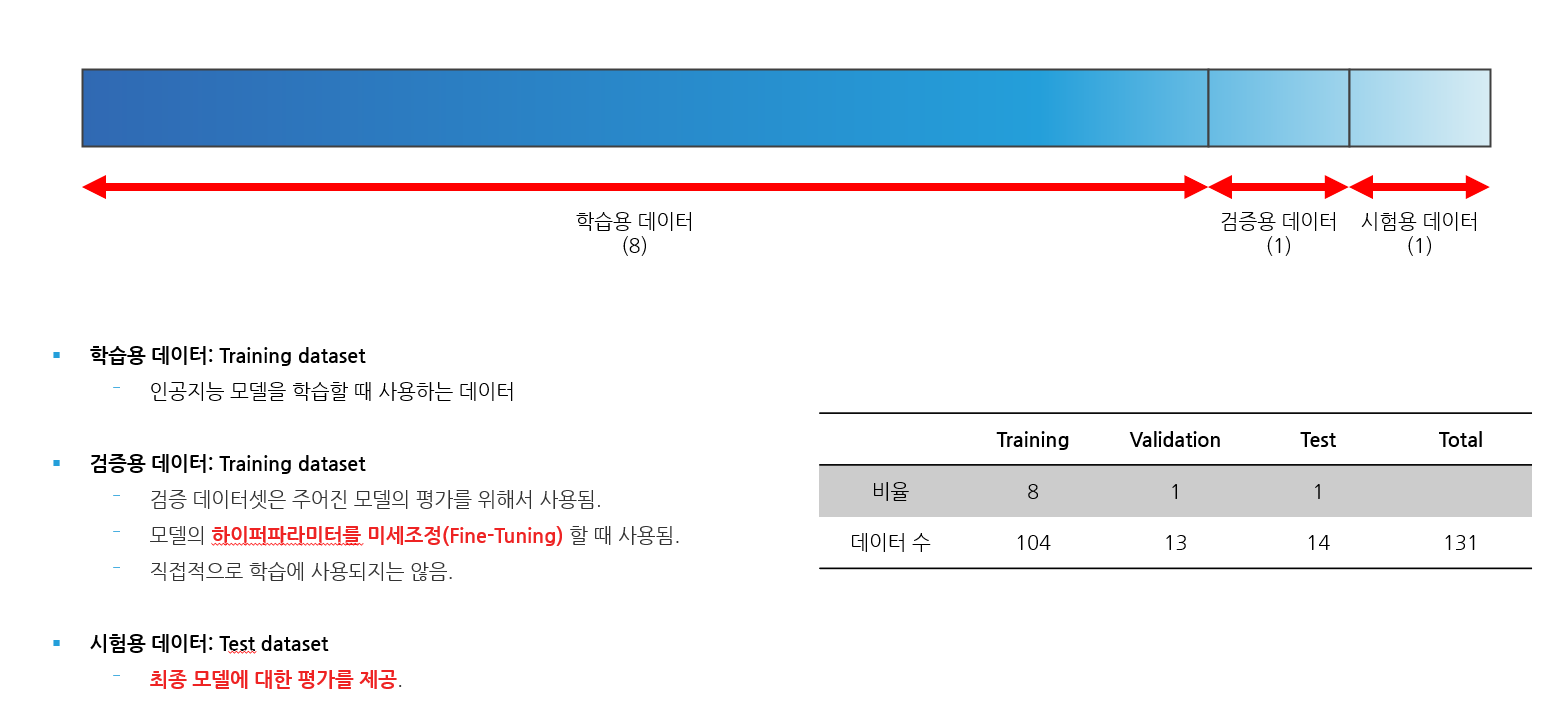


In [4]:
# Block 4
train_ratio = int(0.8 * len(image_data))
validation_ratio = int(0.9 * len(image_data))

train_image = image_data[:train_ratio]
train_label = label_data[:train_ratio]
validation_image = image_data[train_ratio:validation_ratio]
validation_label = label_data[train_ratio:validation_ratio]
test_image = image_data[validation_ratio:]
test_label = label_data[validation_ratio:]


train_image, train_label = shuffle(train_image, train_label)
validation_image, validation_label = shuffle(validation_image, validation_label)
test_image, test_label = shuffle(test_image, test_label)

print(train_image.shape, np.min(train_image), np.max(train_image))
print(train_label.shape, np.min(train_label), np.max(train_label))
print(validation_image.shape, np.min(validation_image), np.max(validation_image))
print(validation_label.shape, np.min(validation_label), np.max(validation_label))
print(test_image.shape, np.min(test_image), np.max(test_image))
print(test_label.shape, np.min(test_label), np.max(test_label))

(104, 128, 128, 1) 0.0 1.0
(104, 128, 128, 1) 0.0 1.0
(13, 128, 128, 1) 0.0 1.0
(13, 128, 128, 1) 0.0 1.0
(14, 128, 128, 1) 0.0 1.0
(14, 128, 128, 1) 0.0 1.0


# 인공지능 모델 정의하기
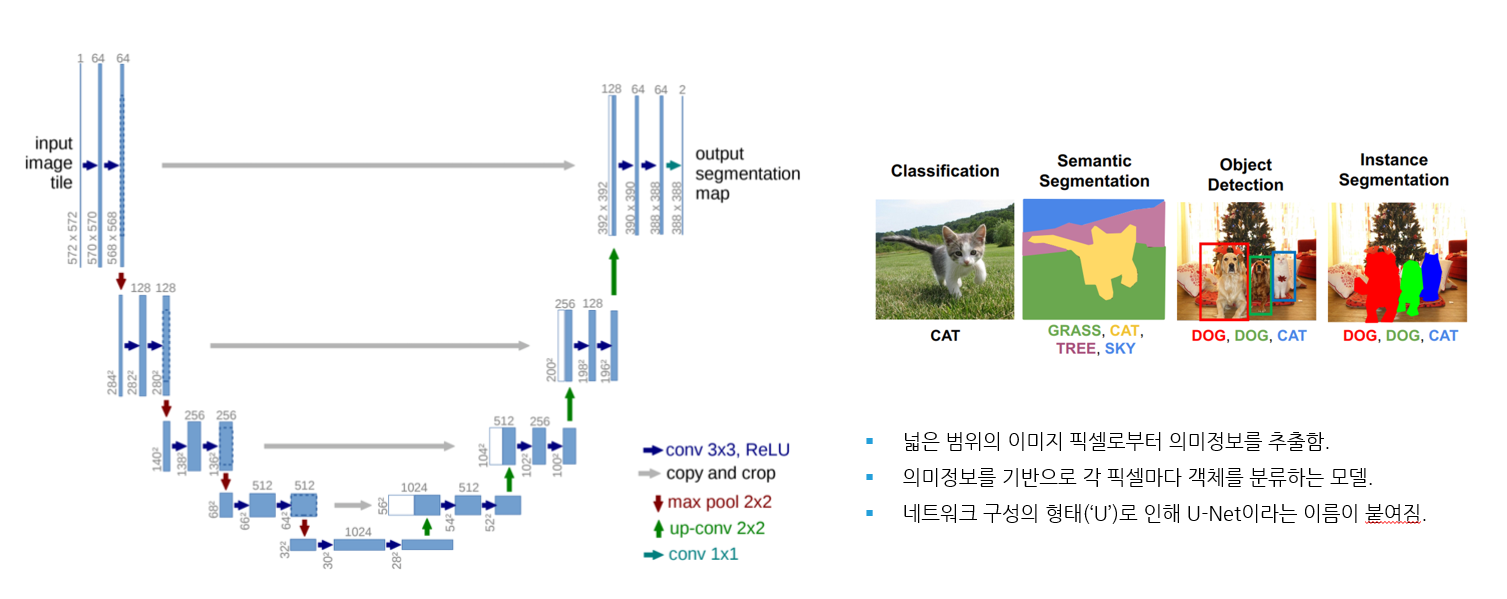

In [5]:
# Block 5
import tensorflow as tf
import MyUNet
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, History, ReduceLROnPlateau, EarlyStopping
import tensorflow.keras.backend as K

# 모델 빌드하기
inp_shape = train_image[0].shape    #inp_shape = (256,256,1)
print(train_image[0].shape)
model = MyUNet.build_model(inp_shape, 1)

# 모델 컴파일하기
model.compile(optimizer=Adam(learning_rate=0.001), loss=MyUNet.dice_coef_loss, metrics=[MyUNet.dice_coef, 'acc'])

# 모델 학습할 때 사용할 콜백 함수 정의하기
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
earlystopper = EarlyStopping(monitor='val_loss', patience=15, verbose=1)
callbacks_list = [reduce_lr, earlystopper]

# 모델 구조 보여주기
model.summary()

(128, 128, 1)


2024-05-21 16:52:47.710918: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 16:52:48.313504: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78906 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:c1:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [6]:
# Block 6
print(train_image.shape, np.min(train_image), np.max(train_image))
print(train_label.shape, np.min(train_label), np.max(train_label))
print(validation_image.shape, np.min(validation_image), np.max(validation_image))
print(validation_label.shape, np.min(validation_label), np.max(validation_label))


(104, 128, 128, 1) 0.0 1.0
(104, 128, 128, 1) 0.0 1.0
(13, 128, 128, 1) 0.0 1.0
(13, 128, 128, 1) 0.0 1.0


In [7]:
# Block 7
from datetime import datetime
startTime = datetime.now()

batch_size = 4
epochs = 10

print('Start Time : {0}'.format(startTime))

# 모델 학습하기
hist = model.fit(train_image, train_label, batch_size=batch_size, epochs=epochs, verbose=1,
              validation_data=(validation_image, validation_label), 
              shuffle=True, callbacks=callbacks_list)

endTime = datetime.now()
runTime = endTime - startTime

print('End Time : {0}'.format(endTime))
print('Running Time : ' + str(runTime))

print('Done training')

Start Time : 2024-05-21 16:52:49.440939
Epoch 1/10


2024-05-21 16:52:53.485703: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8201
2024-05-21 16:52:55.493164: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fcd87697850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-21 16:52:55.493221: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-05-21 16:52:55.497939: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-21 16:52:55.624450: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26/26 [==============================] - 13s 43ms/step - loss: 0.5562 - dice_coef: 0.4438 - acc: 0.8858 - val_loss: 0.7941 - val_dice_coef: 0.2163 - val_acc: 0.1180 - lr: 0.0010
Epoch 2/10
26/26 [==============================] - 1s 21ms/step - loss: 0.4394 - dice_coef: 0.5606 - acc: 0.9597 - val_loss: 0.7207 - val_dice_coef: 0.2940 - val_acc: 0.5262 - lr: 0.0010
Epoch 3/10
26/26 [==============================] - 1s 22ms/step - loss: 0.3973 - dice_coef: 0.6027 - acc: 0.9601 - val_loss: 0.6881 - val_dice_coef: 0.3265 - val_acc: 0.6069 - lr: 0.0010
Epoch 4/10
26/26 [==============================] - 1s 23ms/step - loss: 0.3171 - dice_coef: 0.6829 - acc: 0.9689 - val_loss: 0.5983 - val_dice_coef: 0.4126 - val_acc: 0.8557 - lr: 0.0010
Epoch 5/10
26/26 [==============================] - 1s 22ms/step - loss: 0.2518 - dice_coef: 0.7482 - acc: 0.9755 - val_loss: 0.6588 - val_dice_coef: 0.3543 - val_acc: 0.9032 - lr: 0.0010
Epoch 6/10
26/26 [==============================] - 1s 21ms/step - los

# 학습된 모델 로드 및 테스트하기

In [8]:
# Block 8
from tensorflow.keras.models import load_model

best_model_path = '../2_result/model_best.h5'
model = load_model(best_model_path, custom_objects={'dice_coef_loss': MyUNet.dice_coef_loss, 'dice_coef': MyUNet.dice_coef})


In [9]:
# Block 9
print(test_image.shape, np.min(test_image), np.max(test_image))
print(test_label.shape, np.min(test_label), np.max(test_label))

(14, 128, 128, 1) 0.0 1.0
(14, 128, 128, 1) 0.0 1.0


In [10]:
# Block 10
predicted = model.predict(test_image, batch_size=4, verbose=1)

4/4 [==============================] - 0s 61ms/step


# 인공지능 성능평가
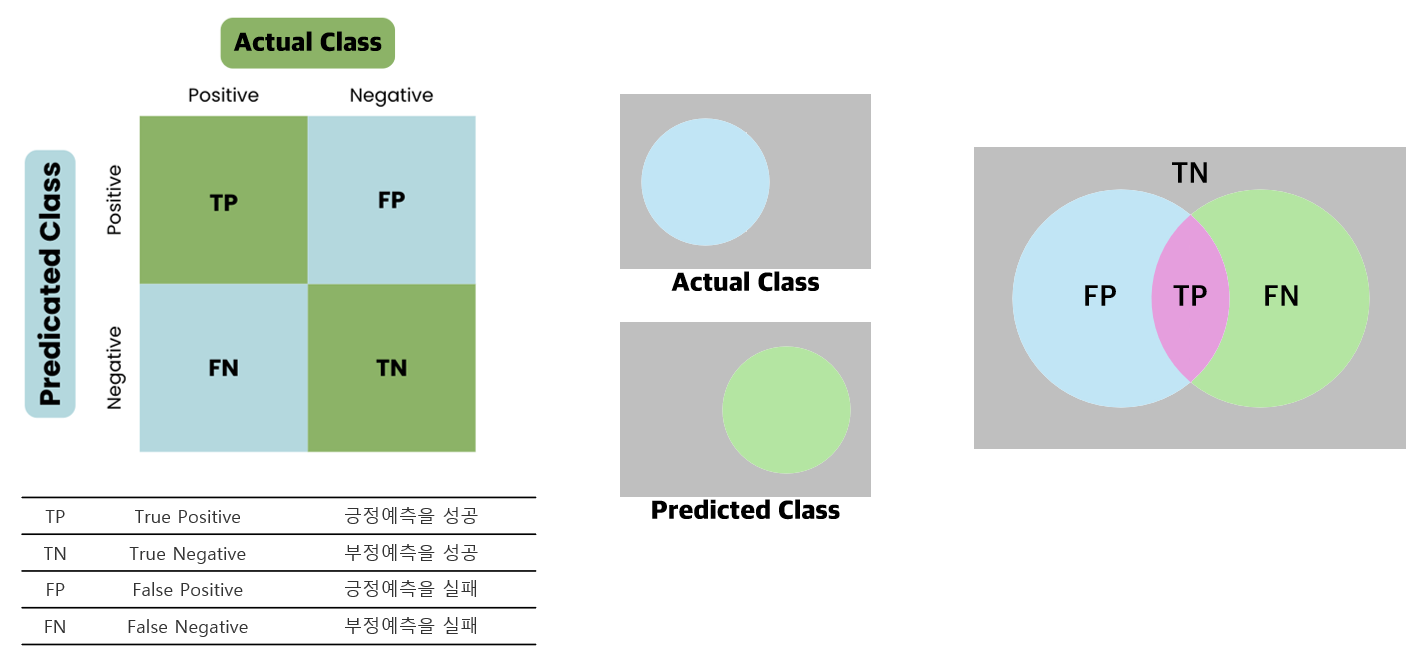


In [11]:
# Block 11
from tabulate import tabulate

row_data1, head1 = cu.returnTable(test_label, predicted, 0.5)
print(tabulate(row_data1, headers=head1, tablefmt="grid"))


Done save result...
+----------+---------------+---------------+-------------+------------+-------+
|   Weight |   Sensitivity |   Specificity |   Precision |   Accuracy |   DSC |
+==========+===============+===============+=============+============+=======+
|      0.5 |         92.84 |         99.46 |        94.9 |      98.84 | 93.73 |
+----------+---------------+---------------+-------------+------------+-------+


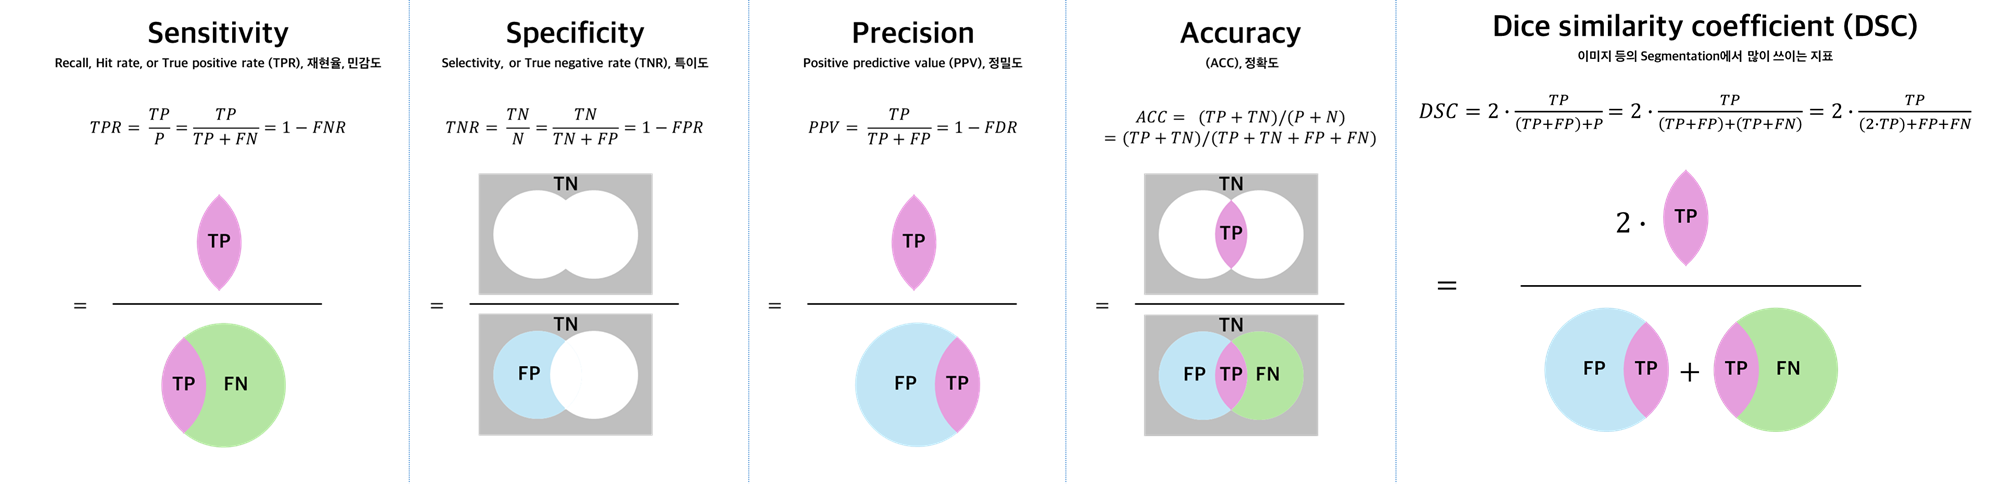

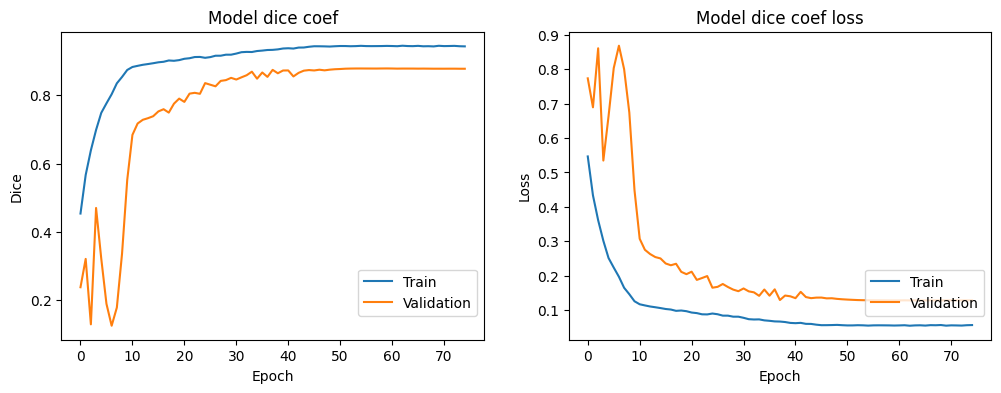

In [12]:
# Block 12

hist_path = '../2_result/hist.csv'
hist = pd.read_csv(hist_path)
hist = dict(hist)

fig = plt.figure(figsize=(12, 4))
    
ax1 = fig.add_subplot(1,2,1)
ax1.plot(hist['dice_coef'])
ax1.plot(hist['val_dice_coef'])
ax1.set_title('Model dice coef')
ax1.set_ylabel('Dice')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper right', bbox_to_anchor=(1, 0.25))

ax2 = fig.add_subplot(1,2,2)
ax2.plot(hist['loss'])
ax2.plot(hist['val_loss'])
ax2.set_title('Model dice coef loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper right', bbox_to_anchor=(1, 0.25))



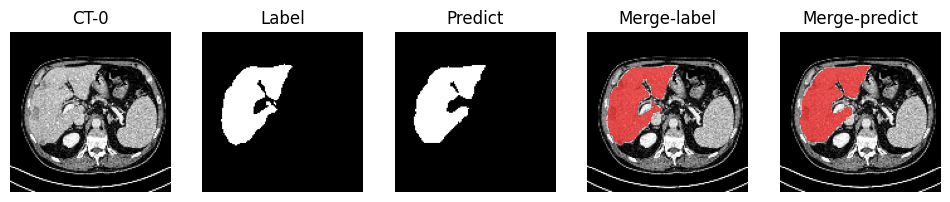

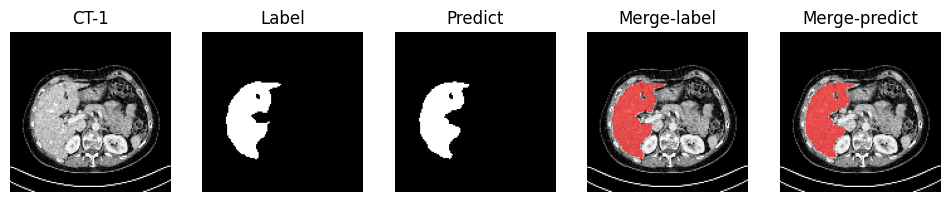

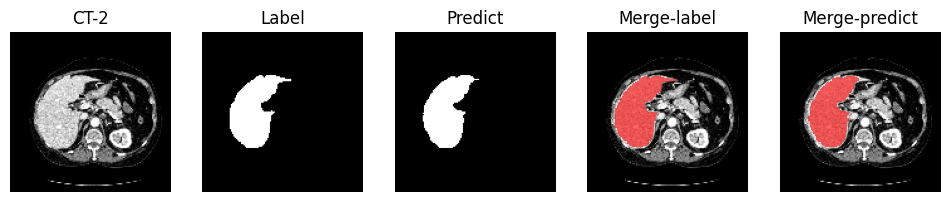

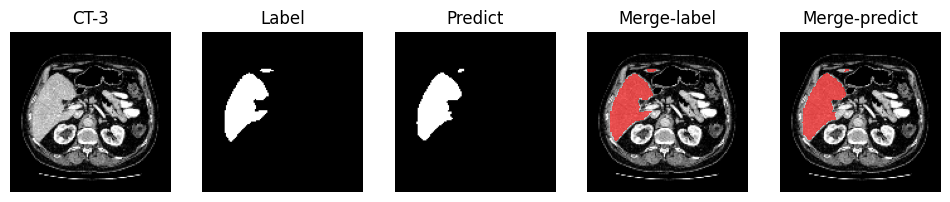

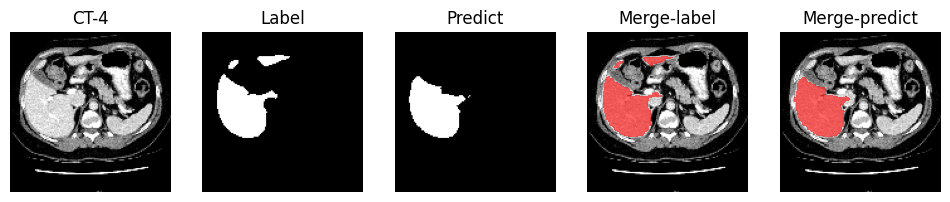

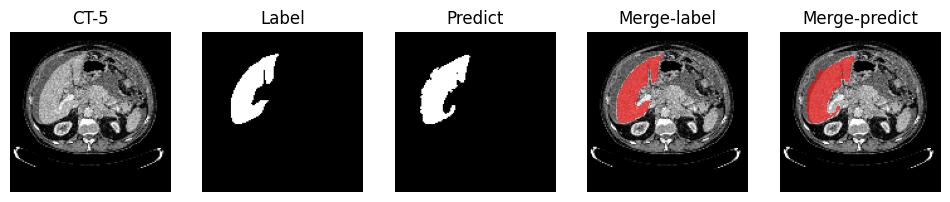

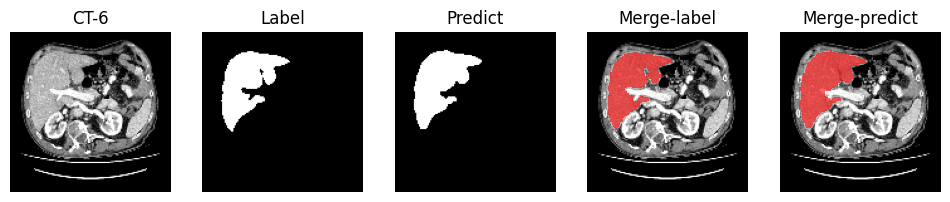

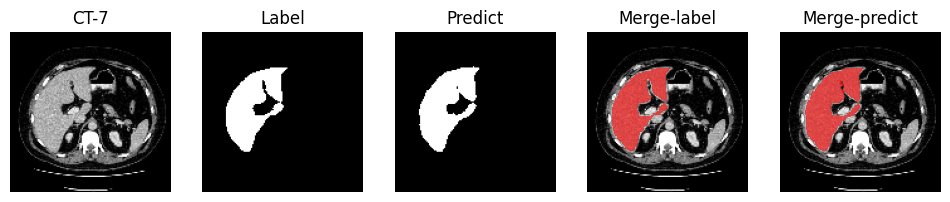

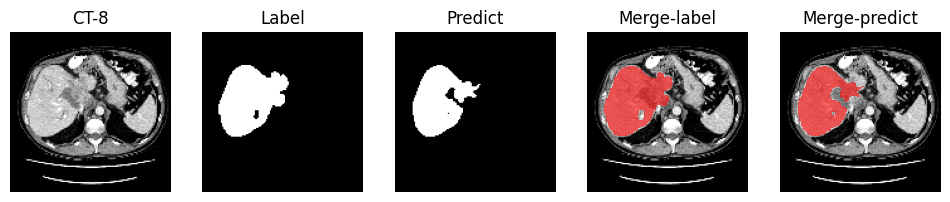

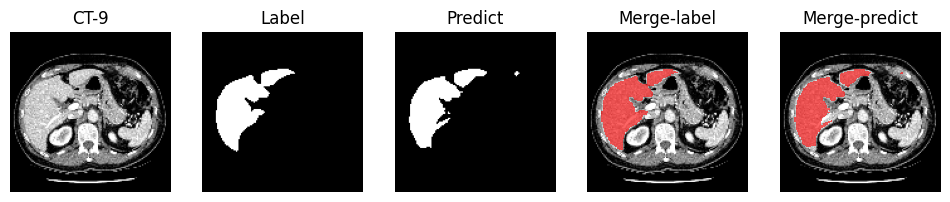

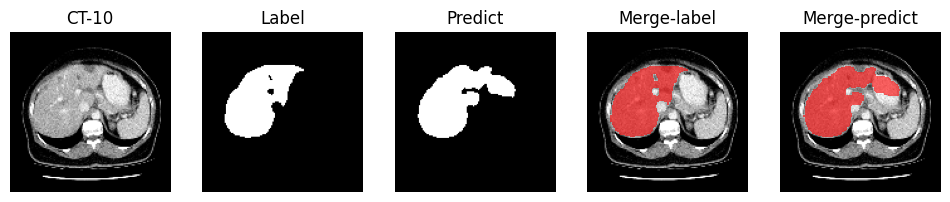

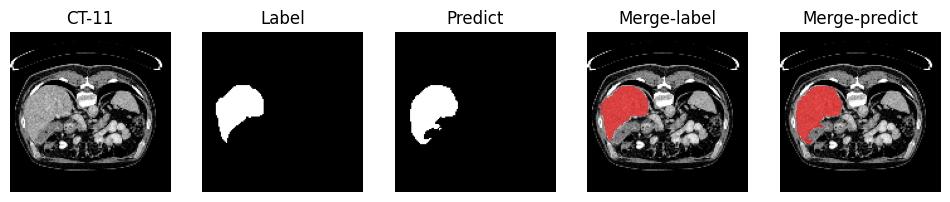

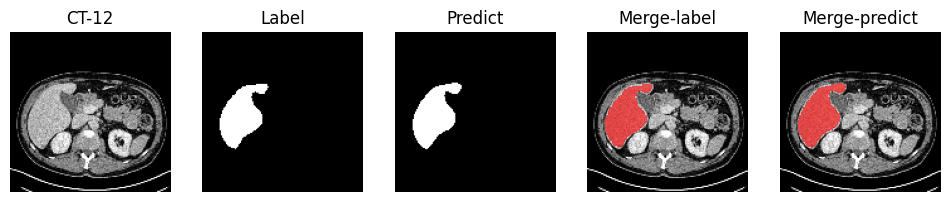

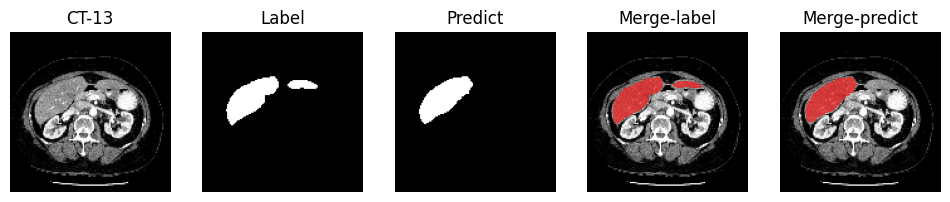

In [13]:
# Block 13
for i in range(0, len(test_image)):
    image = test_image[i, :, :, 0]
    label = test_label[i, :, :, 0]
    predi = predicted[i, :, :, 0] > 0.5
    
    fig = plt.figure(figsize=(12, 12))
    
    ax1 = fig.add_subplot(2,5,1)
    ax1.imshow(image,cmap='gray')
    ax1.axis('off')
    ax1.set_title(f'CT-{i}')
    
    ax2 = fig.add_subplot(2,5,2)
    ax2.imshow(label,cmap='gray')
    ax2.axis('off')
    ax2.set_title('Label')
        
    ax3 = fig.add_subplot(2,5,3)
    ax3.imshow(predi,cmap='gray')
    ax3.axis('off')
    ax3.set_title('Predict')
    
    ax4 = fig.add_subplot(2,5,4)
    ax4.imshow(image,cmap='gray')
    tmpMask = label
    maskedRegion = np.ma.masked_where(tmpMask == 0, tmpMask)
    ax4.imshow(maskedRegion,cmap='hsv' ,alpha=0.6)
    ax4.axis('off')
    ax4.set_title('Merge-label');
    
    ax5 = fig.add_subplot(2,5,5)
    ax5.imshow(image,cmap='gray')
    tmpMask = predi
    maskedRegion = np.ma.masked_where(tmpMask == 0, tmpMask)
    ax5.imshow(maskedRegion,cmap='hsv' ,alpha=0.6)
    ax5.axis('off')
    ax5.set_title('Merge-predict')